# HOLOGAN

This notebook is for implementing 3D representations from natural image from the paper [HoloGAN: Unsupervised Learning of 3D Representations From Natural Images](https://arxiv.org/abs/1904.01326) with [Tensorflow](https://www.tensorflow.org/).

[CelebA dataset](https://www.kaggle.com/jessicali9530/celeba-dataset) dataset, which is 128x128 size, will be used.

Reference:[thunguyenphuoc's Github](https://github.com/thunguyenphuoc/HoloGAN) (Parameters, 3D rotation, trilinear resampling refered)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from sklearn.utils import shuffle
import cv2
import glob
import math
import datetime

/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/frame

## Parameters

In [3]:
algorithm = 'Hologan'

num_epoch  = 10

learning_rate=0.0001

z_dim=128

imgx_size=128
imgy_size=128

batch_size = 32

load_model = False
train_model = True

save_path = "./saved_models/Hologan"

## Import CelebA Dataset

In [4]:
celebA_list = glob.glob('./../../../Server1/kyushik/GenerativeModel/img_align_celeba/*.jpg')

print("CelebA dataset Length: {}".format(len(celebA_list)))

CelebA dataset Length: 202599


## 3D Rotation, Trilinear Resampling

Reference: [thunguyenphuoc's Github](https://github.com/thunguyenphuoc/HoloGAN)

In [5]:
def tf_repeat(x, n_repeats):

    rep = tf.ones(shape=[1, n_repeats], dtype = 'int32')
    x = tf.matmul(tf.reshape(x, (-1,1)), rep)
    return tf.reshape(x, [-1])

def tf_interpolate(voxel, x, y, z, out_size):
    batch_size = tf.shape(voxel)[0]
    height = tf.shape(voxel)[1]
    width = tf.shape(voxel)[2]
    depth = tf.shape(voxel)[3]
    n_channels = tf.shape(voxel)[4]

    x = tf.cast(x, 'float32')
    y = tf.cast(y, 'float32')
    z = tf.cast(z, 'float32')

    out_height = out_size[1]
    out_width = out_size[2]
    out_depth = out_size[3]
    out_channel = out_size[4]

    zero = tf.zeros([], dtype='int32')
    max_y = tf.cast(height - 1, 'int32')
    max_x = tf.cast(width - 1, 'int32')
    max_z = tf.cast(depth - 1, 'int32')

    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1
    z0 = tf.cast(tf.floor(z), 'int32')
    z1 = z0 + 1

    x0 = tf.clip_by_value(x0, zero, max_x)
    x1 = tf.clip_by_value(x1, zero, max_x)
    y0 = tf.clip_by_value(y0, zero, max_y)
    y1 = tf.clip_by_value(y1, zero, max_y)
    z0 = tf.clip_by_value(z0, zero, max_z)
    z1 = tf.clip_by_value(z1, zero, max_z)

    base = tf_repeat(tf.range(batch_size) * width * height * depth,
                     out_height * out_width * out_depth)

    base_z0 = base + z0 * width * height
    base_z1 = base + z1 * width * height

    base_z0_y0 = base_z0 + y0 * width
    base_z0_y1 = base_z0 + y1 * width
    base_z1_y0 = base_z1 + y0 * width
    base_z1_y1 = base_z1 + y1 * width

    idx_a = base_z0_y0 + x0
    idx_b = base_z0_y1 + x0
    idx_c = base_z0_y0 + x1
    idx_d = base_z0_y1 + x1

    idx_e = base_z1_y0 + x0
    idx_f = base_z1_y1 + x0
    idx_g = base_z1_y0 + x1
    idx_h = base_z1_y1 + x1


    voxel_flat = tf.reshape(voxel, [-1, n_channels])
    voxel_flat = tf.cast(voxel_flat, 'float32')
    Ia = tf.gather(voxel_flat, idx_a)
    Ib = tf.gather(voxel_flat, idx_b)
    Ic = tf.gather(voxel_flat, idx_c)
    Id = tf.gather(voxel_flat, idx_d)
    Ie = tf.gather(voxel_flat, idx_e)
    If = tf.gather(voxel_flat, idx_f)
    Ig = tf.gather(voxel_flat, idx_g)
    Ih = tf.gather(voxel_flat, idx_h)

    x0_f = tf.cast(x0, 'float32')
    x1_f = tf.cast(x1, 'float32')
    y0_f = tf.cast(y0, 'float32')
    y1_f = tf.cast(y1, 'float32')
    z0_f = tf.cast(z0, 'float32')
    z1_f = tf.cast(z1, 'float32')


    wa = tf.expand_dims(((x1_f - x) * (y1_f - y) * (z1_f-z)), 1)
    wb = tf.expand_dims(((x1_f - x) * (y - y0_f) * (z1_f-z)), 1)
    wc = tf.expand_dims(((x - x0_f) * (y1_f - y) * (z1_f-z)), 1)
    wd = tf.expand_dims(((x - x0_f) * (y - y0_f) * (z1_f-z)), 1)

    we = tf.expand_dims(((x1_f - x) * (y1_f - y) * (z-z0_f)), 1)
    wf = tf.expand_dims(((x1_f - x) * (y - y0_f) * (z-z0_f)), 1)
    wg = tf.expand_dims(((x - x0_f) * (y1_f - y) * (z-z0_f)), 1)
    wh = tf.expand_dims(((x - x0_f) * (y - y0_f) * (z-z0_f)), 1)


    output = tf.add_n([wa * Ia, wb * Ib, wc * Ic, wd * Id,  we * Ie, wf * If, wg * Ig, wh * Ih])
    return output

def tf_voxel_meshgrid(height, width, depth, homogeneous = False):
    with tf.variable_scope('voxel_meshgrid'):
        z_t, y_t, x_t = tf.meshgrid(tf.range(depth, dtype = tf.float32),
                                    tf.range(height, dtype = tf.float32),
                                    tf.range(width, dtype = tf.float32), indexing='ij')

        x_t_flat = tf.reshape(x_t, (1, -1))
        y_t_flat = tf.reshape(y_t, (1, -1))
        z_t_flat = tf.reshape(z_t, (1, -1))


        grid = tf.concat([x_t_flat, y_t_flat, z_t_flat], axis=0)
        if homogeneous:
            ones = tf.ones_like(x_t_flat)
            grid = tf.concat([grid, ones], axis = 0)
        return grid

def tf_rotation_around_grid_centroid(view_params, shapenet_viewer = False):

    batch_size = tf.shape(view_params)[0]

    azimuth    = tf.reshape(view_params[:, 0], (batch_size, 1, 1))
    elevation  = tf.reshape(view_params[:, 1], (batch_size, 1, 1))


    if shapenet_viewer == False:
        azimuth = (azimuth - tf.constant(math.pi * 0.5))

    ones = tf.ones_like(azimuth)
    zeros = tf.zeros_like(azimuth)
    batch_Rot_Y = tf.concat([
        tf.concat([tf.cos(azimuth),  zeros, -tf.sin(azimuth), zeros], axis=2),
        tf.concat([zeros, ones,  zeros,zeros], axis=2),
        tf.concat([tf.sin(azimuth),  zeros, tf.cos(azimuth), zeros], axis=2),
        tf.concat([zeros, zeros, zeros, ones], axis=2)], axis=1)


    batch_Rot_Z = tf.concat([
        tf.concat([tf.cos(elevation),  tf.sin(elevation),  zeros, zeros], axis=2),
        tf.concat([-tf.sin(elevation), tf.cos(elevation),  zeros, zeros], axis=2),
        tf.concat([zeros, zeros, ones,  zeros], axis=2),
        tf.concat([zeros, zeros, zeros, ones], axis=2)], axis=1)


    transformation_matrix = tf.matmul(batch_Rot_Z, batch_Rot_Y)
    if tf.shape(view_params)[1] == 2:
        return transformation_matrix
    else:
        scale = tf.reshape(view_params[:, 2], (batch_size, 1, 1))
        batch_Scale= tf.concat([
            tf.concat([scale,  zeros,  zeros, zeros], axis=2),
            tf.concat([zeros, scale,  zeros, zeros], axis=2),
            tf.concat([zeros, zeros,  scale,  zeros], axis=2),
            tf.concat([zeros, zeros,  zeros, ones], axis=2)], axis=1)
    return transformation_matrix, batch_Scale

def tf_rotation_resampling(voxel_array, transformation_matrix, params, Scale_matrix = None, size=64, new_size=128):
    batch_size = tf.shape(voxel_array)[0]
    n_channels = voxel_array.get_shape()[4].value
    target = tf.zeros([ batch_size, new_size, new_size, new_size])

    T = tf.constant([[1,0,0, -size * 0.5],
                  [0,1,0, -size * 0.5],
                  [0,0,1, -size * 0.5],
                  [0,0,0,1]])
    T = tf.tile(tf.reshape(T, (1, 4, 4)), [batch_size, 1, 1])


    T_new_inv = tf.constant([[1, 0, 0, new_size * 0.5],
                             [0, 1, 0, new_size * 0.5],
                             [0, 0, 1, new_size * 0.5],
                             [0, 0, 0, 1]])
    T_new_inv = tf.tile(tf.reshape(T_new_inv, (1, 4, 4)), [batch_size, 1, 1])



    x_shift = tf.reshape(params[:, 3], (batch_size, 1, 1))
    y_shift = tf.reshape(params[:, 4], (batch_size, 1, 1))
    z_shift = tf.reshape(params[:, 5], (batch_size, 1, 1))

    ones = tf.ones_like(x_shift)
    zeros = tf.zeros_like(x_shift)

    T_translate = tf.concat([
        tf.concat([ones, zeros, zeros, x_shift], axis=2),
        tf.concat([zeros, ones, zeros, y_shift], axis=2),
        tf.concat([zeros, zeros, ones, z_shift], axis=2),
        tf.concat([zeros, zeros, zeros, ones], axis=2)], axis=1)
    total_M = tf.matmul(tf.matmul(tf.matmul(
        tf.matmul(T_new_inv, T_translate), Scale_matrix), transformation_matrix), T)


    try:
        total_M = tf.matrix_inverse(total_M)

        total_M = total_M[:, 0:3, :] #Ignore the homogenous coordinate so the results are 3D vectors
        grid = tf_voxel_meshgrid(new_size, new_size, new_size, homogeneous=True)
        grid = tf.tile(tf.reshape(grid,
        (1, tf.to_int32(grid.get_shape()[0]) , tf.to_int32(grid.get_shape()[1]))), [batch_size, 1, 1])
        grid_transform = tf.matmul(total_M, grid)
        x_s_flat = tf.reshape(grid_transform[:, 0, :], [-1])
        y_s_flat = tf.reshape(grid_transform[:, 1, :], [-1])
        z_s_flat = tf.reshape(grid_transform[:, 2, :], [-1])
        input_transformed = tf_interpolate(voxel_array, x_s_flat, y_s_flat, z_s_flat,
                                [batch_size, new_size, new_size, new_size, n_channels])
        target= tf.reshape(input_transformed, [batch_size, new_size, new_size, new_size, n_channels])

        return target, grid_transform
    except tf.InvalidArgumentError:
        return None

def tf_3D_transform(voxel_array, view_params, size=64, new_size=128, shapenet_viewer=False):

    M, S = tf_rotation_around_grid_centroid(view_params[:, :3], shapenet_viewer=shapenet_viewer)
    target, grids = tf_rotation_resampling(voxel_array, M,
                params=view_params, Scale_matrix=S, size = size, new_size=new_size)
    
    return target

def generate_random_rotation_translation(batch_size, elevation_low=10,
                                         elevation_high=170, azimuth_low=0, azimuth_high=359,
                                         transX_low=-3, transX_high=3,
                                         transY_low=-3, transY_high=3,
                                         transZ_low=-3, transZ_high=3,
                                         scale_low=1.0, scale_high=1.0,
                                         with_translation=False, with_scale=False):
    
    params = np.zeros((batch_size, 6))
    column = np.arange(0, batch_size)
    azimuth = np.random.randint(azimuth_low, 
                azimuth_high, (batch_size)).astype(np.float) * math.pi / 180.0
    temp = np.random.randint(elevation_low, elevation_high, (batch_size))
    elevation = (90. - temp.astype(np.float)) * math.pi / 180.0
    params[column, 0] = azimuth
    params[column, 1] = elevation

    if with_translation:
        shift_x = transX_low + np.random.random(batch_size) * (transX_high - transX_low)
        shift_y = transY_low + np.random.random(batch_size) * (transY_high - transY_low)
        shift_z = transZ_low + np.random.random(batch_size) * (transZ_high - transZ_low)
        params[column, 3] = shift_x
        params[column, 4] = shift_y
        params[column, 5] = shift_z

    if with_scale:
        scale = float(np.random.uniform(scale_low, scale_high))
        params[column, 2] = scale
    else:
        params[column, 2] = 1.0

    return params


def transform_voxel_to_match_image(tensor):
    tensor = tf.transpose(tensor, [0, 2, 1, 3, 4])
    tensor = tensor[:, ::-1, :, :, :]
    return tensor

## Hologan Network

In [6]:
def spectral_norm(w, name, iteration=1):
    w_shape = w.shape.as_list()
    w = tf.reshape(w, [-1, w_shape[-1]])

    u = tf.get_variable(name+"u", [1, w_shape[-1]], 
                initializer=tf.random_normal_initializer(), trainable=False)

    u_hat = u
    v_hat = None
    for i in range(iteration):
        v_ = tf.matmul(u_hat, tf.transpose(w))
        v_hat = tf.nn.l2_normalize(v_)

        u_ = tf.matmul(v_hat, w)
        u_hat = tf.nn.l2_normalize(u_)

    u_hat = tf.stop_gradient(u_hat)
    v_hat = tf.stop_gradient(v_hat)

    sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))

    with tf.control_dependencies([u.assign(u_hat)]):
        w_norm = w / sigma
        w_norm = tf.reshape(w_norm, w_shape)

    return w_norm


def AdaIn(x, z, size, name):
    mean, cov=tf.nn.moments(x, axes=list(range(len(x.get_shape())))[1:-1], keep_dims=True)
    sigma=tf.sqrt(cov)    
    
    w_init=tf.random_normal_initializer(stddev=0.02)
    b_init=tf.constant_initializer(0.0)
    
    mlp_out=tf.layers.dense(z, size*2 ,activation=tf.nn.relu, kernel_initializer=w_init, \
                            bias_initializer=b_init, name=name)
    
    sigma_z=mlp_out[:,:size]
    gamma_z=mlp_out[:,size:]
    
    sigma_z=tf.reshape(sigma_z,tf.shape(mean))
    gamma_z=tf.reshape(gamma_z,tf.shape(mean))
    
    output=sigma_z*(x-mean)/(sigma+1e-8) + gamma_z
    
    return output

def style_dis_layer(input_, filter_size, name):
    
    w_init=tf.random_normal_initializer(stddev=0.02)
    b_init=tf.constant_initializer(0.0)
    
    w = tf.get_variable(name+'w', shape=[5, 5, input_.get_shape()[-1], filter_size], \
                       initializer=tf.truncated_normal_initializer(stddev=0.02))
    b = tf.get_variable(name+'b', [filter_size], initializer=b_init)
    
    d = tf.nn.conv2d(input_, filter=spectral_norm(w,name), strides=[1, 2, 2, 1], padding='SAME') + b
    
    d=tf.contrib.layers.instance_norm(d)
    d_mean, d_cov= tf.nn.moments(d, axes=[1,2], keep_dims=True)
    d_mean=tf.reshape(d_mean, [tf.shape(input_)[0], filter_size])
    d_cov=tf.reshape(d_cov, [tf.shape(input_)[0], filter_size])
    d_style=tf.concat((d_mean,d_cov), 0)

    d_style=tf.layers.dense(d_style, 1, kernel_initializer=w_init,
                            bias_initializer=b_init, name=name+'style')
    d=tf.nn.leaky_relu(d)
    
    return d, d_style


def Generator(z, pose):
   
    with tf.variable_scope("gen", reuse=tf.AUTO_REUSE) as scope:
        
        with tf.variable_scope('constant'):
            con=tf.get_variable('const', [4,4,4,512],
                                initializer=tf.random_normal_initializer(stddev=0.02))
            x=tf.tile(tf.expand_dims(con, 0), (batch_size, 1, 1, 1, 1))
            g0=AdaIn(x, z, 512, 'a0')
            g0=tf.nn.leaky_relu(g0)
        
        g1=tf.layers.conv3d_transpose(g0, 256, kernel_size=3, strides=(2,2,2), padding='SAME')
        g1=AdaIn(g1, z,256, 'a1')
        g1=tf.nn.leaky_relu(g1)
        
        g2=tf.layers.conv3d_transpose(g1, 128, kernel_size=3, strides=(2,2,2), padding='SAME')
        g2=AdaIn(g2, z, 128, 'a2')
        g2=tf.nn.leaky_relu(g2)
        
        g2_r = tf_3D_transform(g2, pose, 16, 16)
        g2_r = transform_voxel_to_match_image(g2_r)      
        
        g3=tf.layers.conv3d_transpose(g2_r, 64, kernel_size=3, strides=(1,1,1), padding='SAME')
        g3=tf.nn.leaky_relu(g3)
        
        g4=tf.layers.conv3d_transpose(g3, 64, kernel_size=3, strides=(1,1,1), padding='SAME')
        g4=tf.nn.leaky_relu(g4)
        
        g5=tf.reshape(g4, shape=
            [tf.shape(g4)[0],tf.shape(g4)[1],tf.shape(g4)[2],tf.shape(g4)[3]*tf.shape(g4)[4]])
        
        g5=tf.layers.conv2d_transpose(g5, filters=512, kernel_size=1, strides=1, padding='SAME')
        g5=tf.nn.leaky_relu(g5)
        
        g6=tf.layers.conv2d_transpose(g5, filters=256, kernel_size=4, strides=2, padding='SAME')
        g6=AdaIn(g6,z, 256, 'a3')
        g6=tf.nn.leaky_relu(g6)
        
        g7=tf.layers.conv2d_transpose(g6, filters=64, kernel_size=4, strides=2, padding='SAME')
        g7=AdaIn(g7,z, 64, 'a4')
        g7=tf.nn.leaky_relu(g7)
        
        g8=tf.layers.conv2d_transpose(g7, filters=32, kernel_size=4, strides=2, padding='SAME')
        g8=AdaIn(g8,z, 32 , 'a5')
        g8=tf.nn.leaky_relu(g8)
        
        out=tf.layers.conv2d_transpose(g8, filters=3, 
                        activation=tf.nn.tanh , kernel_size=4, strides=(1,1), padding='SAME')
        
    return out
        
def Discriminator(image):
    with tf.variable_scope("dis",reuse=tf.AUTO_REUSE) as scope:
        
        d0=tf.layers.conv2d(image, 64, activation =tf.nn.leaky_relu, kernel_size=5, strides=(2,2))
        
        d1, d1_style=style_dis_layer(d0, 128, 'dis1')
        d2, d2_style=style_dis_layer(d1, 256, 'dis2')
        d3, d3_style=style_dis_layer(d2, 512, 'dis3')
        d4, d4_style=style_dis_layer(d3, 1024, 'dis4')
        
        w_init=tf.random_normal_initializer(stddev=0.02)
        b_init=tf.constant_initializer(0.0)

        TF=tf.layers.dense(tf.layers.flatten(d4), 1, kernel_initializer=w_init,
                                bias_initializer=b_init, name='dis5')
        
        e1=tf.layers.dense(tf.layers.flatten(d4), 128,activation=tf.nn.leaky_relu,
                        kernel_initializer=w_init, bias_initializer=b_init, name='enc1')
        
        z_est=tf.layers.dense(e1, z_dim, activation=tf.nn.tanh, kernel_initializer=w_init,
                    bias_initializer=b_init, name='enc2')

        
        return TF, d1_style, d2_style, d3_style, d4_style, z_est
    
    
def dis_loss(x_f, x_t):
    
    loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_t,
    labels=tf.ones_like(x_t)))+ tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_f,
                                                                        labels=tf.zeros_like(x_f)))
    
    return loss

## Build Graph

In [7]:
tf.reset_default_graph()

x_t=tf.placeholder(tf.float32, shape=[None,imgx_size, imgy_size,3])
z=tf.placeholder(tf.float32, shape=[None, z_dim])
cam_pose=tf.placeholder(tf.float32, shape=[None, 6])
lr=tf.placeholder(tf.float32)

x_f=Generator(z, cam_pose)
F, style1_f,style2_f,style3_f,style4_f, z_f =Discriminator(x_f)
T, style1_t,style2_t,style3_t,style4_t, _   =Discriminator(x_t)

t_vars = tf.trainable_variables()
G_vars = [var for var in t_vars if ('gen' in var.name)]
D_vars = [var for var in t_vars if ('dis' in var.name)]

id_loss=tf.reduce_mean(tf.square(z-z_f))

G_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=F, labels=tf.ones_like(F)))
        + id_loss

D_loss=dis_loss(F,T)+ dis_loss(style1_f, style1_t)+ dis_loss(style2_f, style2_t)+ 
        dis_loss(style3_f, style3_t)+dis_loss(style4_f, style4_t) + id_loss

G_optim = tf.train.AdamOptimizer(lr, beta1=0.5, beta2=0.999).minimize(G_loss, var_list=G_vars)
D_optim = tf.train.AdamOptimizer(lr, beta1=0.5, beta2=0.999).minimize(D_loss, var_list=D_vars)

# Initialization & Load Model

In [8]:
config = tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=1))
sess = tf.Session(config=config)
Saver=tf.train.Saver()
    
init=tf.global_variables_initializer()
sess.run(init)

Saver = tf.train.Saver()

if load_model == True:
    Saver.restore(sess, load_path)

# Train Hologan

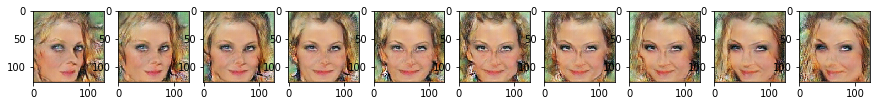

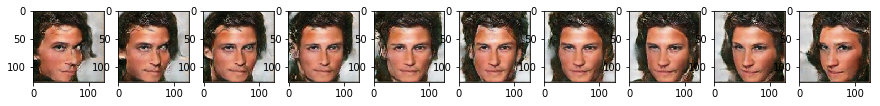

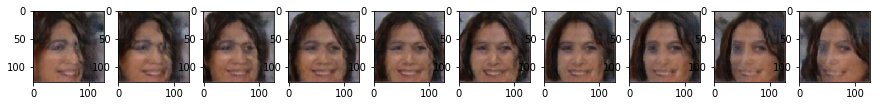

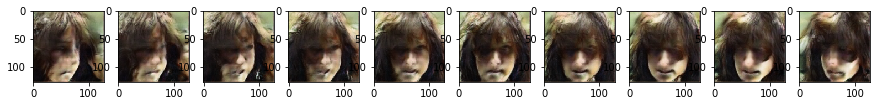

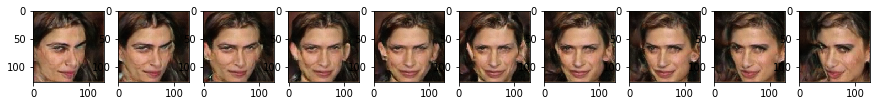

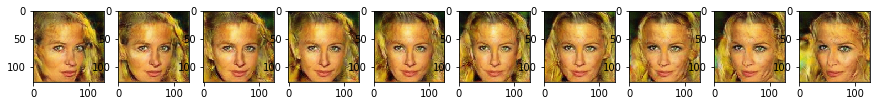

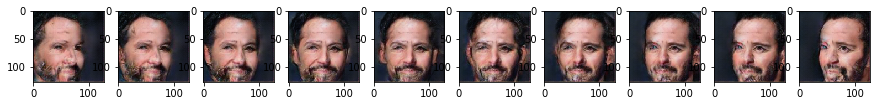

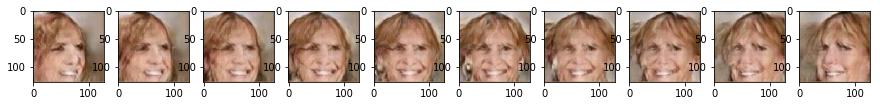

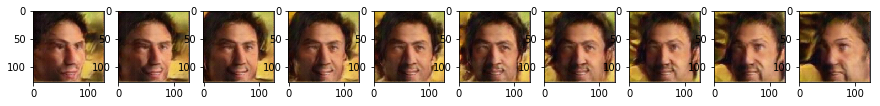

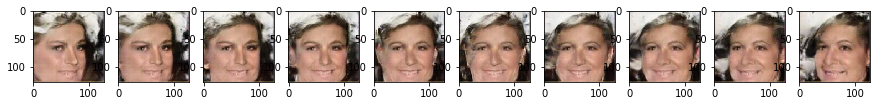

In [9]:
if train_model:
    len_data=len(celebA_list)
    
    for i in range(num_epoch):
        lr_in = learning_rate if i < 25 else (learning_rate * (50 - i) / 25)
        
        np.random.shuffle(celebA_list)
        
        batch_count=0
        
        for j in range(0, len_data, batch_size):
            if j + batch_size < len_data:
                x_in = np.zeros([batch_size, imgx_size, imgy_size, 3])
                z_in=np.random.uniform(-1.0,1.0, (batch_size, z_dim))
                cam_pose_in=generate_random_rotation_translation(batch_size,
                                                         70,110,220,320,0,0,0,0,0,0,1,1)

                for k in range(batch_size):
                    img_temp = cv2.cvtColor(cv2.imread(celebA_list[j + k]),cv2.COLOR_BGR2RGB)
                    x_in[k,:,:,:] = img_temp[45:45 + imgx_size, 25: 25+imgy_size, :]

            x_in=x_in.reshape((-1, imgx_size, imgy_size, 3))
            x_in=x_in/255.0
            x_in=(x_in-0.5)/0.5

            
            sess.run(D_optim, feed_dict={x_t:x_in, z:z_in, cam_pose:cam_pose_in,lr:lr_in})
            sess.run(G_optim, feed_dict={x_t:x_in, z:z_in, cam_pose:cam_pose_in,lr:lr_in})
            sess.run(G_optim, feed_dict={x_t:x_in, z:z_in, cam_pose:cam_pose_in,lr:lr_in})
            
            print ("Batch: {}".format(j/len_data), end="\r")
        
        
        if (i==5) & (i==4)  :
            Saver.save(sess, save_path)
    
        z_test=np.random.uniform(-1.0,1.0, (batch_size, z_dim))
        f, ax=plt.subplots(1,10, figsize=(15,15))

        for u in range(10):
            angle=np.linspace(220,310,10)
            pose_test=np.tile(np.array([[angle[u] * math.pi / 180.0, 
                                    0 * math.pi / 180.0, 1.0, 0, 0, 0]]), (batch_size, 1))

            test_img=sess.run(x_f, feed_dict={z:z_test, cam_pose:pose_test})
            test_img=(test_img+1.0)/2.0
            ax[u].imshow(test_img[0])
            
        plt.show()
            

## Test Result

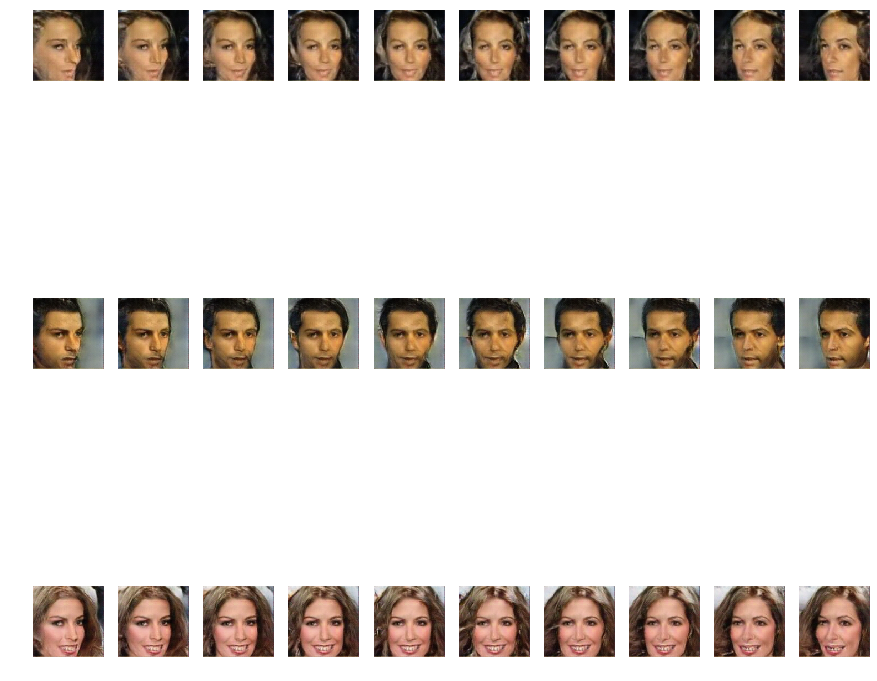

In [23]:
f, [ax1,ax2,ax3]=plt.subplots(3,10, figsize=(15,15))
z_test=np.random.uniform(-1.0,1.0, (batch_size, z_dim))


for u in range(10):
    angle=np.linspace(220,310,10)
    pose_test=np.tile(np.array([[angle[u] * math.pi / 180.0,
                                0 * math.pi / 180.0, 1.0, 0, 0, 0]]), (batch_size, 1))

    test_img=sess.run(x_f, feed_dict={z:z_test, cam_pose:pose_test})

    test_img=(test_img+1.0)/2.0

    ax1[u].imshow(test_img[0])
    ax2[u].imshow(test_img[1])
    ax3[u].imshow(test_img[2])
    ax1[u].axis("off")
    ax2[u].axis("off")
    ax3[u].axis("off")

plt.show()